In [1]:
import os 
os.getcwd()

import warnings 
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd 
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.special import rel_entr

from engine_hms_model import (
    KagglePaths, LocalPaths, ModelConfig
)

pd.set_option('display.max_columns', None)

PATHS = KagglePaths if os.path.exists(KagglePaths.OUTPUT_DIR) else LocalPaths
print("Output Dir: ", PATHS.OUTPUT_DIR)

Output Dir:  ./outputs/


In [2]:
def get_non_overlap(train_csv, targets):

    df = train_csv.groupby(['eeg_id'] + targets).agg({
            'spectrogram_id': 'first',
            'spectrogram_label_offset_seconds': ['min', 'max'],
            'eeg_label_offset_seconds': ['min', 'max', lambda x: x.sample(1)],
            'patient_id': 'first',
            'expert_consensus': 'first',
            'total_votes': 'sum',
            'entropy': 'mean',
            'is_hard': 'mean'
        }).reset_index()

    df.columns = ["eeg_id"] + targets + \
        ['spectrogram_id', 'min', 'max', 'eeg_off_min', 'eeg_off_max', 'eeg_off_sample', 'patient_id', 'target', 'total_votes', 'average_entropy', 'is_hard']

    df[targets] = df[targets].apply(lambda x: x / x.sum(), axis=1)

    return df

In [30]:
train_csv = pd.read_csv(PATHS.TRAIN_CSV)
targets = train_csv.columns[-6:].tolist()

print("targets: ", targets)

train_csv['total_votes'] = train_csv[targets].sum(axis=1)

targets_prob = [f"{t.split('_')[0]}_prob" for t in targets]
train_csv[targets_prob] = train_csv[targets].div(train_csv['total_votes'], axis=0)

train_csv['entropy'] = train_csv[targets_prob].apply(lambda row: sum(rel_entr([1/6]*6, row.values+1e-5)), axis=1)
train_csv['is_hard'] = (train_csv['entropy'] < 5.5).astype(int)

train_all = train_csv.groupby(['eeg_id']+targets_prob).agg({
    'spectrogram_id': 'first',
    'spectrogram_label_offset_seconds': ['min', 'max'],
    'eeg_label_offset_seconds': ['min', 'max', lambda x: x.sample(1)],
    'patient_id': 'first',
    'expert_consensus': 'first',
    'total_votes': 'sum',
    'entropy': 'mean',
    'is_hard': 'mean'
}).reset_index()

train_all.columns = ["eeg_id"] + targets_prob + \
    ['spectrogram_id', 'min', 'max', 'eeg_off_min', 'eeg_off_max', 'eeg_off_sample', 'patient_id', 'target', 'total_votes', 'average_entropy', 'is_hard']

# train_all = get_non_overlap(train_csv, targets_prob)
# train_hard = get_non_overlap(train_csv[train_csv['is_hard'] == 1].copy().reset_index(), targets)

# print("train_all: ", train_all.shape)
# print("hard samples: ", train_hard.shape)

train_all.head(15)

targets:  ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


,eeg_id,seizure_prob,lpd_prob,gpd_prob,lrda_prob,grda_prob,other_prob,spectrogram_id,min,max,eeg_off_min,eeg_off_max,eeg_off_sample,patient_id,target,total_votes,average_entropy,is_hard
0,568657,0.000000,0.000000,0.250000,0.000000,0.166667,0.583333,789577333,0.0,16.0,0.0,16.0,6.0,20654,Other,48,4.584192,1.0
1,582999,0.000000,0.857143,0.000000,0.071429,0.000000,0.071429,1552638400,0.0,38.0,0.0,38.0,10.0,20230,LPD,154,4.870032,1.0
2,642382,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,14960202,1008.0,1032.0,0.0,24.0,24.0,5955,Other,2,7.802343,0.0
3,751790,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,618728447,908.0,908.0,0.0,0.0,0.0,38549,GPD,1,7.802343,0.0
4,778705,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,52296320,0.0,0.0,0.0,0.0,0.0,40955,Other,2,7.802343,0.0
5,1629671,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2036345030,0.0,160.0,0.0,160.0,0.0,37481,Seizure,51,7.802343,0.0
6,1895581,0.076923,0.000000,0.000000,0.000000,0.076923,0.846154,128369999,1138.0,1138.0,0.0,0.0,0.0,47999,Other,13,4.847483,1.0
7,2061593,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,320962633,1450.0,1450.0,0.0,0.0,0.0,23828,Other,1,7.802343,0.0
8,2078097,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2074135650,3342.0,3342.0,0.0,0.0,0.0,61174,Other,2,7.802343,0.0
9,2366870,0.000000,0.333333,0.000000,0.000000,0.000000,0.666667,1232582129,0.0,30.0,0.0,30.0,16.0,23633,Other,18,6.134196,0.0


In [37]:
train_hard = train_all[train_all['is_hard']==1]
print(train_hard.shape)

(4094, 18)


unique_spec_id:  11138


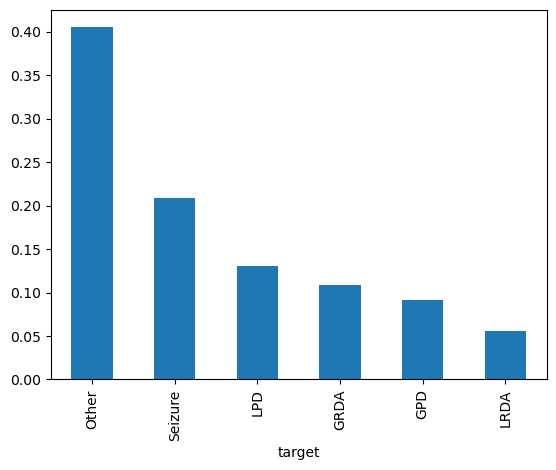

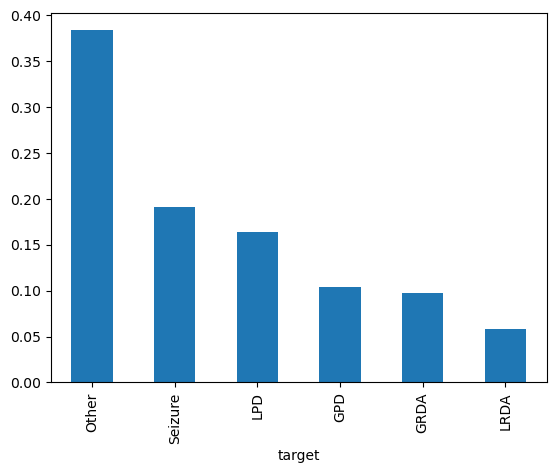

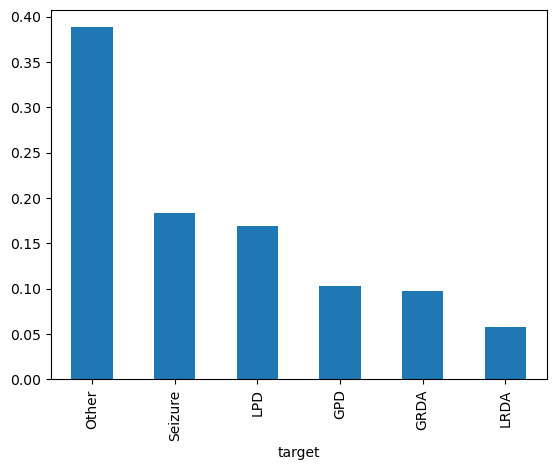

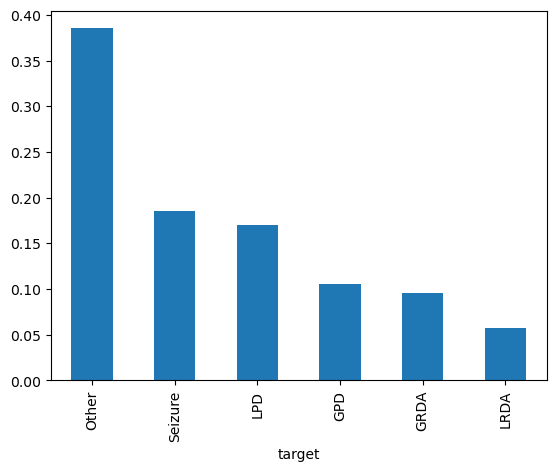

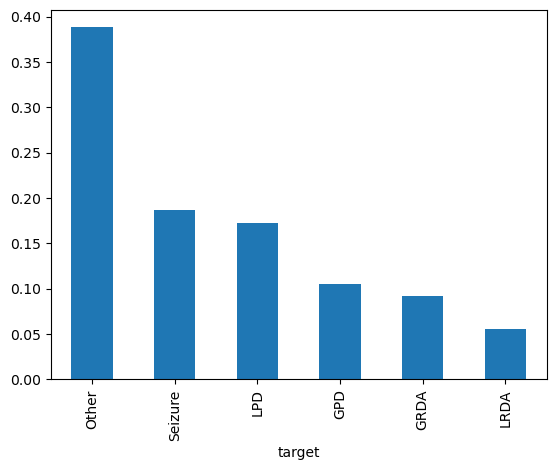

In [57]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)
unique_spec_id = train_all['spectrogram_id'].unique()
print("unique_spec_id: ", len(unique_spec_id))
train_all['fold'] = 5
for fold, (train_index, valid_index) in enumerate(kf.split(unique_spec_id)):
    train_all.loc[train_all['spectrogram_id'].isin(unique_spec_id[valid_index]), 'fold'] = fold

fold_counts = train_all['fold'].value_counts()

target_counts = train_all[train_all['fold'] == 0]['target'].value_counts()
target_counts = target_counts / target_counts.sum()

for fold in range(5):
    target_counts = train_all[train_all['fold'] != fold]['target'].value_counts()
    target_counts = target_counts / target_counts.sum()
    target_counts.plot(kind='bar')
    plt.show()
   

In [24]:
df_sub['seizure_prob']==0

77694    False
77695    False
77696     True
77697     True
77698     True
         ...  
78101    False
78102    False
78103     True
78104    False
78105     True
Name: seizure_prob, Length: 412, dtype: bool

In [ ]:
tgt_list = targets.to_list()

# agg_dict = {
#         'spectrogram_id': 'first',
#         'spectrogram_label_offset_seconds': ['min', 'max'],
#         'patient_id': 'first',
#         'expert_consensus': 'first',
#         'is_hard': lambda x: x.sum() / x.count()
#     }

agg_dict = {
    'spectrogram_id': 'first',
    'spectrogram_label_offset_seconds': ['min', 'max'],
    'patient_id': 'first',
    'expert_consensus': ['first', 'count', 'nunique'],
    'entropy': 'mean',
    'is_hard': lambda x: x.sum() / x.count()
}

for tgt in tgt_list:
    agg_dict[tgt] = 'sum'
    
df_agg = train_csv.groupby(['eeg_id']).agg(agg_dict).reset_index()
df_agg.columns = ['eeg_id','spectrogram_id', 'min', 'max', 'patient_id', 'target', 'target_count', 'target_nunique','averge_entropy', 'is_hard_ratio'] + tgt_list

df_agg['total_votes'] = df_agg[tgt_list].sum(axis=1)
df_agg[tgt_list] = df_agg[tgt_list].apply(lambda x: x / x.sum(), axis=1)

In [ ]:
df_agg[(df_agg['target_count']>1)&(df_agg['target_nunique']>1)].sort_values('target_count', ascending=False).head(50)

In [ ]:
pd.set_option("display.max_rows", None)
df_on_eeg = train_csv[train_csv['eeg_id']==188361788].sort_values('total_votes').reset_index()
df_to_plot = df_on_eeg.groupby('expert_consensus').apply(lambda x: x.sample(1)).reset_index(drop=True)
df_to_plot #[['eeg_id', 'spectrogram_id', 'spectrogram_label_offset_seconds', 'expert_consensus', 'is_hard', 'entropy', 'total_votes'] + tgt_list ]

In [ ]:
df_on_eeg.groupby(targets.tolist()).agg({
    'spectrogram_id': 'count',
    'eeg_label_offset_seconds': ['min', 'max'],
    'spectrogram_label_offset_seconds': ['min', 'max', lambda x: x.sample(1)]
    }).reset_index()

In [ ]:
targets

In [ ]:
df_on_eeg[targets].mean(axis=0), df_on_eeg['spectrogram_label_offset_seconds'].min(), df_on_eeg['spectrogram_label_offset_seconds'].max(), df_on_eeg['eeg_label_offset_seconds'].min(), df_on_eeg['eeg_label_offset_seconds'].max()

In [ ]:
EEG_FEAT_USE =  ['Fp1','T3','C3','O1','Fp2','C4','T4','O2']
EEF_FEAT_INDEX = {x:y for x,y in zip(EEG_FEAT_USE, range(len(EEG_FEAT_USE)))}
EEF_FEAT_INDEX

In [ ]:
def plot_spec(df):

    fig, axs = plt.subplots(2, 2, figsize=(15, 6), sharex=True, sharey=True)

    prefixes = ['LL', 'RL', 'LP', 'RP']

    for ax, prefix in zip(axs.flatten(), prefixes):
        cols = df.filter(regex=f"^{prefix}_").columns
        ax.imshow(df[cols].T, origin="lower", norm="log", cmap="plasma", interpolation="none")
        ax.set_title(prefix, fontsize=12, fontweight="bold")
        ax.set_yticks(np.arange(0, 101, 25.))
        ax.set_yticklabels([0, 5, 10, 15, 20])
        ax.set_xticks(np.arange(0, 301, 75.))
        ax.set_xticklabels(range(df.iloc[0, 0], df.iloc[-1, 0], (df.iloc[-1, 0]-df.iloc[0, 0])//4))

    for ax in axs[:, 0]:
        ax.set_ylabel("Frequency (Hz)")
    for ax in axs[-1, :]:
        ax.set_xlabel("Time (s)")

    fig.tight_layout()
    plt.show()

In [ ]:
spectrogram_id = df_to_plot['spectrogram_id'].values[0]
print(spectrogram_id)

spec_parquet = pd.read_parquet(f"./inputs/hms-harmful-brain-activity-classification/train_spectrograms/{spectrogram_id}.parquet")
print(spec_parquet.shape)

for idx, row in df_to_plot.iterrows():
    start = row['spectrogram_label_offset_seconds']
    spec_part = spec_parquet[(spec_parquet['time'] >= start) & (spec_parquet['time'] <= start+600)]
    print(f"Offset: {start}; Expert Consensus: {row['expert_consensus']}")
    plot_spec(spec_part)
    print("=================================")

In [ ]:
eeg_id = df_to_plot['eeg_id'].values[0]
print(eeg_id)

ch_1, ch_2 = 'Fp1', 'T3' #'Fp1', 'C3' #'T3', 'O1' #

eeg_seq = pd.read_parquet(f"./inputs/hms-harmful-brain-activity-classification/train_eegs/{eeg_id}.parquet")
print(eeg_seq.shape)

fig, axes = plt.subplots(len(df_to_plot), 1, figsize=(10, 2*len(df_to_plot)))
i = 0
for idx, row in df_to_plot.iterrows():
    start = row['eeg_label_offset_seconds']
    label = row['expert_consensus']
    eeg_series = eeg_seq.iloc[int(start*200):int(start*200+50*200), :].values
    x_diff = eeg_series[:,EEF_FEAT_INDEX[ch_1]] - eeg_series[:,EEF_FEAT_INDEX[ch_2]]
    axes[i].plot(x_diff[::5], label=label)
    axes[i].grid()
    axes[i].legend()
    i += 1
    # axes.set_title(f"eeg_id: {eeg_id} | {ch_1} - {ch_2}")

fig.tight_layout()
plt.show()

In [ ]:
(df_agg['is_hard_ratio'] > 0.4).sum()

In [ ]:
tmp = train_csv.groupby('eeg_id')['is_hard'].apply(lambda x: x.sum() / len(x)).sort_values(ascending=False)
tmp[tmp<0.3]

#.plot(kind='hist', bins=50, log=True)

In [ ]:
tmp = train_csv[train_csv['eeg_id']==3397233035 ]

averge_votes = tmp[targets].sum() / tmp['total_votes'].sum()

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
tmp[tmp['is_hard'] == 1][targets_prob].T.plot(ax=ax, legend=False, color='red', ls='--')
tmp[tmp['is_hard'] == 0][targets_prob].T.plot(ax=ax, legend=False, color='blue', ls=":")
averge_votes.plot(ax=ax, color='black', lw=2)
ax.grid()
plt.show()

In [ ]:
tmp[targets].sum() / tmp['total_votes'].sum()

In [ ]:
train_csv[train_csv['is_hard'] == 1]['total_votes'].plot(kind='hist', bins=10, log=True)

In [ ]:
# plot in log scale
train_csv.groupby('eeg_id').size().plot(kind='hist', bins=50, log=True, title='Number of samples per eeg_id')

In [ ]:
train_csv.groupby('eeg_id')['total_votes'].mean().plot(kind='hist', bins=20, log=True, title='Mean total votes per eeg_id')